In [13]:
import anndata
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import gc
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd

from scbasset.utils import *

In [2]:
with open("/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/model/history.pickle", "rb") as f:
    history = pickle.load(f)

In [3]:
history.keys()
keys = 'loss', 'auc', 'auc_1', 'val_loss', 'val_auc', 'val_auc_1'

# Train

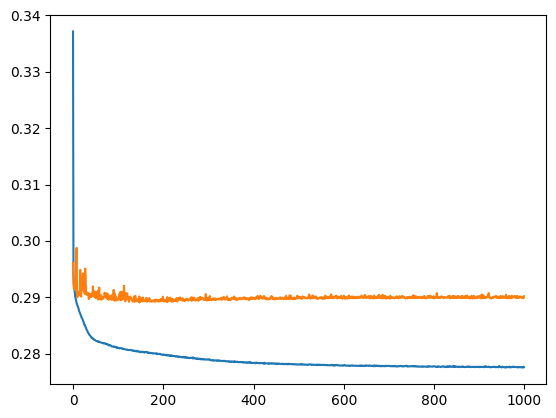

In [4]:
# Plot a line plot of the training loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])

# Val

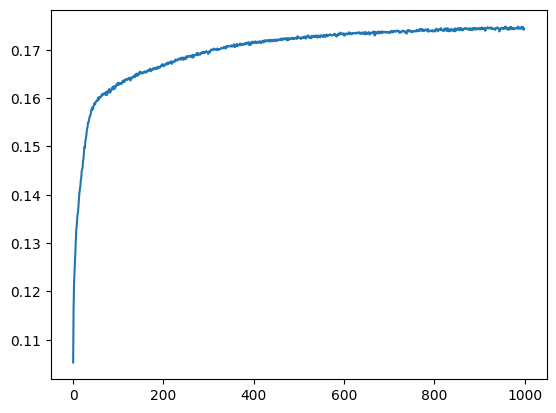

In [8]:
plt.plot(history['auc_1'])

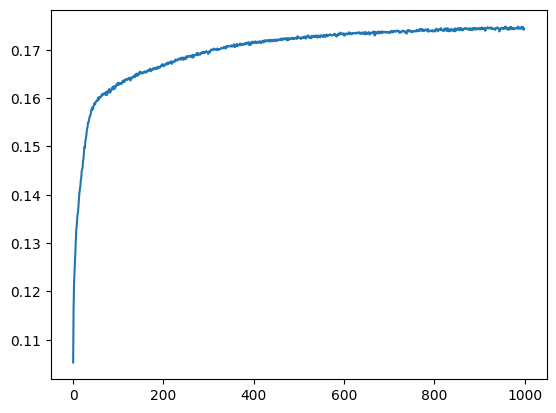

In [9]:
plt.plot(history['auc_1'])

# Test

In [47]:
ad = anndata.read_h5ad("/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/ad.h5ad")
split_file =  "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/splits.h5"
n_cells = ad.shape[0]
ad

AnnData object with n_obs × n_vars = 7998 × 21970
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end', 'n_cells'

In [48]:
# convert to csr matrix
with h5py.File(split_file, 'r') as hf:
    test_ids = hf['test_ids'][:]
m = ad.X.tocoo().transpose().tocsr()
m_test = m[test_ids,:]
del m
gc.collect()

494

In [49]:
# How big
m_test.shape

(1098, 7998)

In [50]:
test_data = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/test_seqs.h5"

In [51]:
 test_ds = tf.data.Dataset.from_generator(
        generator(test_data, m_test),
        output_signature=(
             tf.TensorSpec(shape=(1344,4), dtype=tf.int8),
             tf.TensorSpec(shape=(n_cells), dtype=tf.int8),
        )
    )

In [52]:
 batch = test_ds.batch(1098)

In [53]:
batch_lst = list(batch.as_numpy_iterator())
len(batch_lst)

1

In [54]:
seqs = batch_lst[0][0]
labels = batch_lst[0][1]
seqs.shape, labels.shape

((1098, 1344, 4), (1098, 7998))

In [55]:
trained_model = '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/24Oct23/scbasset/MM168/model/best_model.h5'

In [56]:
# load model
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights(trained_model)

In [62]:
preds = model(seqs).numpy()

In [65]:
labels.shape, preds.shape

((1098, 7998), (1098, 7998))

In [84]:
# Now need to get AUROC, Binary Cross Entropy, and Precision Recall metrics for labels vs preds
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc

def calculate_auroc(y_true, y_score):
    vals = []
    for class_index in range(y_true.shape[-1]):
        if np.unique(y_true[:,class_index]).shape[0] == 1:
            vals.append(np.nan)
            print(f"Class {class_index} only has one class")
        else:
            vals.append( roc_auc_score(y_true[:,class_index], y_score[:,class_index]) )    
    return np.array(vals)

def calculate_aupr(y_true, y_score):
    vals = []
    for class_index in range(y_true.shape[-1]):
        if np.unique(y_true[:,class_index]).shape[0] == 1:
            vals.append(np.nan)
            print(f"Class {class_index} only has one class")
        else:
            vals.append( average_precision_score(y_true[:,class_index], y_score[:,class_index]) )    
    return np.array(vals)

In [79]:
# Calculate AUROC
aurocs = calculate_auroc(labels, preds)

Class 476 only has one class
Class 545 only has one class
Class 961 only has one class
Class 1780 only has one class
Class 2198 only has one class
Class 2256 only has one class
Class 2405 only has one class
Class 2591 only has one class
Class 2847 only has one class
Class 2850 only has one class
Class 2905 only has one class
Class 2929 only has one class
Class 3056 only has one class
Class 3832 only has one class
Class 4161 only has one class
Class 4242 only has one class
Class 5181 only has one class
Class 5292 only has one class
Class 5772 only has one class
Class 5914 only has one class
Class 6261 only has one class
Class 6471 only has one class
Class 7634 only has one class
Class 7896 only has one class


In [85]:
# Calculate AUPR
auprs = calculate_aupr(labels, preds)

Class 476 only has one class
Class 545 only has one class
Class 961 only has one class
Class 1780 only has one class
Class 2198 only has one class
Class 2256 only has one class
Class 2405 only has one class
Class 2591 only has one class
Class 2847 only has one class
Class 2850 only has one class
Class 2905 only has one class
Class 2929 only has one class
Class 3056 only has one class
Class 3832 only has one class
Class 4161 only has one class
Class 4242 only has one class
Class 5181 only has one class
Class 5292 only has one class
Class 5772 only has one class
Class 5914 only has one class
Class 6261 only has one class
Class 6471 only has one class
Class 7634 only has one class
Class 7896 only has one class


In [83]:
np.nanmean(aurocs), np.nanmedian(aurocs), np.nanstd(aurocs)

(0.5852439231623556, 0.586566007347459, 0.050941071769298504)

In [86]:
np.nanmean(auprs), np.nanmedian(auprs), np.nanstd(auprs)

(0.14098570232373733, 0.11609756051770596, 0.10068818954933348)

In [87]:
# BINARY CROSS ENTROPY
bce = tf.keras.losses.BinaryCrossentropy()
bce(labels, preds).numpy()

0.28815606